### Notebook #7

## Table of Contents

1) <a href='#v1' id='top'>Word2Vec V1</a>
2) <a href='#v2'>Word2Vec V2</a>
3) <a href='#v3'>Word2Vec V3</a>
4) <a href='mlp'>MLP Classifier</a>

## Intro

In the previous notebook we both ***trained*** and *tested* our word embeddings on a sample consisting of a quarter of the dataset. The results were encouraging, as they were our best performing model thus far. In order to take it a step further, however, we will now train the word embeddings on the entirety of the dataset to see if the performance improves. We will also experiment with adjustments to the `max_vocab_size` to see if a more robust vocabulary performs better.  

We will again be running the `MLPClassifier` model, but this time on the entire dataset rather than a sample.

**NOTE**  
This is not present in the notebook, but having run `MLPClassifier` on a sample of the dataset using the newly robustly trained model, we encountered an overfitting problem. Running it on the entirety of the dataset rectified that problem.

In [171]:
# importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import regex as re
import string

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


from gensim.models import Word2Vec


import warnings 
warnings.filterwarnings(action = 'ignore')

In [2]:
# reading in csv and checking hed
reddit = pd.read_csv('reddit_comments.csv', index_col=0)

reddit.head()

,label,comment
0,0,NC and NH.
1,0,You do know west teams play against west teams...
2,0,"They were underdogs earlier today, but since G..."
3,0,"This meme isn't funny none of the ""new york ni..."
4,0,I could use one of those tools.


In [3]:
# verifying shape
reddit.shape

(1010714, 2)

## <a href='#top' id='v1'>Word2Vec V1</a>

Here we will tokenize the documents, set `X` and `y`, and train our `word embeddings` on the entire dataset with a `max_vocab_size` of 10,000.

In [4]:
# custom tokenizer function

def tokenizer(series):
    # get values from series
    corpus = series.values
    tokens = [] # empty token list
    
    for document in corpus:
        #removing punctuation
        for punc in string.punctuation:
            document = document.replace(punc, '')
        
        # removing numbers and setting all documents to lowercase    
        document = re.sub("\d+", "", document).lower()
        # splitting documents and appending tokens list
        tokens.append(document.split(' '))
        
    
        

    return tokens

In [5]:
# setting X and y
X = reddit['comment']
y = reddit['label']

In [6]:
# tokenizing comments through custom fucntion
tokenized_data = tokenizer(X)

In [8]:
# training word2vec model 
embeddings = Word2Vec(tokenized_data, window=5, min_count=25, workers=4, size=300, max_vocab_size=10000 )
embeddings.train(tokenized_data, total_examples=embeddings.corpus_count, epochs=embeddings.epochs)

(32242067, 52702745)

We can now run a brief test on our new embeddings to see how they fair on the similarity of certain key words.  
These words are not necessarily indicators of sarcasm, but words that we may associate with the meaning or intention behind sarcastic remarks as well as their opposites.

In [16]:
embeddings.most_similar('honest')

[('fair', 0.5500063896179199),
 ('happy', 0.3940263092517853),
 ('helpful', 0.39203542470932007),
 ('consistent', 0.3889119327068329),
 ('accurate', 0.3884361982345581),
 ('able', 0.3717784285545349),
 ('intelligent', 0.36361128091812134),
 ('worried', 0.3615310490131378),
 ('pretend', 0.36099451780319214),
 ('careful', 0.35628825426101685)]

In [165]:
embeddings.most_similar('intention')

[('intent', 0.5688397288322449),
 ('interpretation', 0.5436697006225586),
 ('motives', 0.5065232515335083),
 ('imagination', 0.5025438070297241),
 ('expertise', 0.4868161678314209),
 ('knowledge', 0.4723774790763855),
 ('reputation', 0.4644463360309601),
 ('intentions', 0.46426910161972046),
 ('worldview', 0.46414148807525635),
 ('motive', 0.46105632185935974)]

In [168]:
# similarity scores for 'serious' and 'joking'
serious = embeddings.most_similar('serious')
joking = embeddings.most_similar('joking')

# setting to dataframe
pd.DataFrame(
        data={"serious": [word for word, sim in serious], 
            "joking": [word for word, sim in joking]})

,serious,joking
0,sarcastic,sarcastic
1,sincere,kidding
2,vague,exaggerating
3,pessimistic,lying
4,humorous,talking
5,conscious,trolling
6,stressful,overreacting
7,genuine,arguing
8,rhetorical,bummed
9,joking,worried


In [169]:
# finding most similar words to 'truth' and 'lie'
lie = embeddings.most_similar('lie')
truth = embeddings.most_similar('truth')

# setting to dataframe to visualize
pd.DataFrame(
        data={"lie": [word for word, sim in lie], 
            "truth": [word for word, sim in truth]})

,lie,truth
0,talk,bible
1,say,gospel
2,complain,facts
3,lied,reality
4,brag,lies
5,happen,story
6,listen,msm
7,criticize,koran
8,tell,illuminati
9,hurt,hivemind


These results look very good at a glance. We, as humans, can see the relationships between most of these words and the target. There likewise a very encouraging lack of completely unrelated or nonesense words.  

There are, however, limitations, as having a limited vocabulary of 10,000 words means that certain words are missing (including possibly the key-est of words):

**not present : genuine, mislead, misleading, sarcastic**

We will nevertheless vectorize these documents and run them through our model since there is a visible improvement in the 'similarity' scores.

**Below we will define our vectorizer function, run our tokens through it, and perform a train/test split in preparation for modeling**

In [9]:
# function to vectorize documents
def sentence(document):
    
    size = embeddings.vector_size # setting constant document size
    word_vec_doc = np.zeros(size) # populating list of document size with zeros 
    count = 1 # word count to be used for average
    
    # looping through documents
    for word in document:
        # checking if word exists in document
        if word in embeddings:
            count +=1
            word_vec_doc += embeddings[word] # adding word embedding to doc embedding
    
    word_vec_doc = word_vec_doc / count # taking average of embeddings
    
    return word_vec_doc

In [10]:
# setting vectors to variable
document_vectors = [sentence(doc) for doc in tokenized_data]

In [11]:
# setting X to be document vectors
X = document_vectors

In [12]:

# initial split into rem and test
X_rem, X_test, y_rem, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [13]:
# secondary split into train and val
X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size=0.25, random_state=42)

**Here we will perform an MLP Classifier on our trained embeddings with a `max_iter` of 50 and fit it to our train set.**

In [14]:
# instantiating mlp classifier, setting max iter to 100
MLP = MLPClassifier(verbose=True, max_iter=50, random_state=42)

# fitting to train
MLP.fit(X_train, y_train)

Iteration 1, loss = 0.59870891
Iteration 2, loss = 0.57957896
Iteration 3, loss = 0.57236994
Iteration 4, loss = 0.56760017
Iteration 5, loss = 0.56384728
Iteration 6, loss = 0.56098465
Iteration 7, loss = 0.55836949
Iteration 8, loss = 0.55613608
Iteration 9, loss = 0.55415146
Iteration 10, loss = 0.55236107
Iteration 11, loss = 0.55096479
Iteration 12, loss = 0.54968556
Iteration 13, loss = 0.54821630
Iteration 14, loss = 0.54697472
Iteration 15, loss = 0.54591776
Iteration 16, loss = 0.54493178
Iteration 17, loss = 0.54403885
Iteration 18, loss = 0.54296323
Iteration 19, loss = 0.54221189
Iteration 20, loss = 0.54146407
Iteration 21, loss = 0.54093657
Iteration 22, loss = 0.53983933
Iteration 23, loss = 0.53928058
Iteration 24, loss = 0.53867438
Iteration 25, loss = 0.53803515
Iteration 26, loss = 0.53750221
Iteration 27, loss = 0.53693058
Iteration 28, loss = 0.53633226
Iteration 29, loss = 0.53608161
Iteration 30, loss = 0.53555823
Iteration 31, loss = 0.53507104
Iteration 32, los

MLPClassifier(max_iter=50, random_state=42, verbose=True)

In [15]:
# printing resulting train and val scores
print(f'Train: {MLP.score(X_train, y_train)}')
print(f'Val: {MLP.score(X_val, y_val)}')

Train: 0.7378870975118113
Val: 0.697813824145555


**Our embeddings' performance has improved by nearly 3% compared to our last test and the gap between train and validation has also narrowed.**  

We can also take a quick peak at the precision and recall, but will ultimately do a more in-depth evaluation at the end.

In [21]:
# setting predictions to variable
val_predict = MLP.predict(X_val)

In [22]:
# instantiating and printing classification report
report = classification_report(y_val, val_predict, target_names=['Non-Sarcastic', 'Sarcastic'])
print(report)


               precision    recall  f1-score   support

Non-Sarcastic       0.69      0.73      0.71     94698
    Sarcastic       0.71      0.67      0.69     94811

     accuracy                           0.70    189509
    macro avg       0.70      0.70      0.70    189509
 weighted avg       0.70      0.70      0.70    189509



Our precision and recall both hover around the high 60s, low 70s, and there does not exist a big difference between the `sarcastic` and `non-sarcastic` results, though their respective "preferences" for precision and recall are flipped.

## <a href='#top' id='v2'>Word2Vec V2</a>

Here we will again be training the model on the same data, only changing the `max_vocab_size` from 10,000 to 25,000.

In [172]:
# reinstantiating more precise word2vec 
embeddings = Word2Vec(tokenized_data, window=5, min_count=25, workers=4, size=300, max_vocab_size=25000 )
embeddings.train(tokenized_data, total_examples=embeddings.corpus_count, epochs=embeddings.epochs)


(36950366, 52702745)

In [26]:
embeddings.most_similar('honest')

[('fair', 0.5486595034599304),
 ('inclusive', 0.47523725032806396),
 ('respectful', 0.4735337793827057),
 ('polite', 0.47271180152893066),
 ('prepared', 0.46505624055862427),
 ('trusted', 0.4546806812286377),
 ('pretending', 0.44425106048583984),
 ('concerned', 0.437551349401474),
 ('informed', 0.4371459484100342),
 ('satisfied', 0.43627816438674927)]

In [27]:
embeddings.most_similar('genuine')

[('respectful', 0.5474706888198853),
 ('vague', 0.5428102612495422),
 ('condescending', 0.5399175882339478),
 ('constructive', 0.5218842029571533),
 ('supportive', 0.5168256163597107),
 ('pedantic', 0.5151475667953491),
 ('rational', 0.5137948989868164),
 ('sensible', 0.5127853751182556),
 ('polite', 0.5117471218109131),
 ('mature', 0.5090007185935974)]

In [29]:
embeddings.most_similar('sarcastic')

[('joking', 0.617906928062439),
 ('pedantic', 0.6122118234634399),
 ('condescending', 0.540844202041626),
 ('rude', 0.5087727904319763),
 ('serious', 0.5017151236534119),
 ('sarcasm', 0.4932788014411926),
 ('downvoted', 0.47953370213508606),
 ('witty', 0.4528225064277649),
 ('satire', 0.443932443857193),
 ('intentional', 0.44102251529693604)]

In [173]:
# finding most similar words to 'truth' and 'lie'
lie = embeddings.most_similar('lie')
truth = embeddings.most_similar('truth')

# setting to dataframe to visualize
pd.DataFrame(
        data={"lie": [word for word, sim in lie], 
            "truth": [word for word, sim in truth]})

,lie,truth
0,talk,msm
1,say,bible
2,complain,facts
3,happen,lies
4,lied,gospel
5,lying,media
6,brag,story
7,tell,irony
8,listen,narrative
9,prosecute,masses


In [174]:
# similarity scores for 'serious' and 'joking'
serious = embeddings.most_similar('serious')
joking = embeddings.most_similar('joking')

# setting to dataframe
pd.DataFrame(
        data={"serious": [word for word, sim in serious], 
            "joking": [word for word, sim in joking]})

,serious,joking
0,sarcastic,sarcastic
1,vague,kidding
2,genuine,lying
3,minor,talking
4,dramatic,trolling
5,irrelevant,forgetting
6,condescending,mistaken
7,joking,arguing
8,helpful,delusional
9,tough,worried


In [176]:
embeddings.most_similar('misleading')

[('factual', 0.5981446504592896),
 ('incorrect', 0.5849772691726685),
 ('untrue', 0.5742781162261963),
 ('vague', 0.5733296871185303),
 ('clickbait', 0.5684908628463745),
 ('inaccurate', 0.5575202703475952),
 ('informative', 0.5404921770095825),
 ('biased', 0.5248669385910034),
 ('irrelevant', 0.5225300788879395),
 ('accurate', 0.5214860439300537)]

### Observations:  
- the words similar to honest are quite different
- sarcastic, genuine, and misleading are present, though mislead is not
- now that `sarcastic` is present, it is the most related word to both 'joking' and 'serious', which is interesting
- the words related to truth are all over the place, which is not all that surprising given the state of reddit and the internet at large. Truth can be a nebulous concept 

-------------------------------------------------------------------------------------------------------------------------------------------------------------

Now that we have our new embeddings, we can run them through the MLP Classifier again, this time with an added `early_stopping` parameter.

In [30]:
# setting new x to new vectors
new_vectors = [sentence(doc) for doc in tokenized_data]
new_X = new_vectors

In [31]:
# performing new train/test split
X_rem, X_test, y_rem, y_test = train_test_split(new_X, y, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size=0.25, random_state=42)

In [32]:
 # running mlp classifier again with max iter at 50
MLP = MLPClassifier(verbose=True, max_iter=50, random_state=42, early_stopping=True)

# fitting to new x train
MLP.fit(X_train, y_train)

Iteration 1, loss = 0.59426382
Validation score: 0.690570
Iteration 2, loss = 0.57416647
Validation score: 0.698151
Iteration 3, loss = 0.56622327
Validation score: 0.701634
Iteration 4, loss = 0.56075659
Validation score: 0.702654
Iteration 5, loss = 0.55691964
Validation score: 0.702179
Iteration 6, loss = 0.55354609
Validation score: 0.705398
Iteration 7, loss = 0.55095895
Validation score: 0.702813
Iteration 8, loss = 0.54866152
Validation score: 0.706471
Iteration 9, loss = 0.54640018
Validation score: 0.704501
Iteration 10, loss = 0.54478100
Validation score: 0.707122
Iteration 11, loss = 0.54293299
Validation score: 0.705486
Iteration 12, loss = 0.54132024
Validation score: 0.704308
Iteration 13, loss = 0.54023780
Validation score: 0.706436
Iteration 14, loss = 0.53868364
Validation score: 0.707861
Iteration 15, loss = 0.53746006
Validation score: 0.707315
Iteration 16, loss = 0.53645475
Validation score: 0.705152
Iteration 17, loss = 0.53527136
Validation score: 0.706453
Iterat

MLPClassifier(early_stopping=True, max_iter=50, random_state=42, verbose=True)

In [33]:
print(f'Train: {MLP.score(X_train, y_train)}')
print(f'Val: {MLP.score(X_val, y_val)}')

Train: 0.7296922216398195
Val: 0.7072751162213932


**Our model has now comfortably surpassed 70% accuracy and has further decreased the gap between validation and train**

In [34]:
new_val_predict = MLP.predict(X_val)

In [35]:
new_report = classification_report(y_val, new_val_predict, target_names=['Non-Sarcastic', 'Sarcastic'])
print(new_report)

               precision    recall  f1-score   support

Non-Sarcastic       0.70      0.73      0.71     94698
    Sarcastic       0.72      0.69      0.70     94811

     accuracy                           0.71    189509
    macro avg       0.71      0.71      0.71    189509
 weighted avg       0.71      0.71      0.71    189509



Again, the precision and recall scores are around 0.7 and consistent between classes, which is unsurprising given their 50/50 distribution.

## <a href='#top' id='v3'>Word2Vec V3</a>

We will make one final ammendment to our embeddings by doubling the `max_vocab_size` to 50,000.

In [177]:
embeddings = Word2Vec(tokenized_data, window=5, min_count=25, workers=4, size=300, max_vocab_size=50000 )
embeddings.train(tokenized_data, total_examples=embeddings.corpus_count, epochs=embeddings.epochs)

(38626307, 52702745)

In [37]:
embeddings.most_similar('sarcastic')

[('joking', 0.631554126739502),
 ('pedantic', 0.6057127714157104),
 ('satirical', 0.5891914367675781),
 ('detained', 0.5603727698326111),
 ('condescending', 0.5538766384124756),
 ('serious', 0.5244185924530029),
 ('sarcasm', 0.5157309770584106),
 ('rude', 0.5056517720222473),
 ('cautious', 0.4985797107219696),
 ('downvoted', 0.4956313371658325)]

In [38]:
embeddings.most_similar('mislead')

[('detained', 0.4850125312805176),
 ('accusing', 0.48035579919815063),
 ('mocking', 0.4757020175457001),
 ('offending', 0.4719669222831726),
 ('appease', 0.4678475856781006),
 ('accuse', 0.4623815417289734),
 ('warn', 0.460408091545105),
 ('exploited', 0.4589082896709442),
 ('insulted', 0.45725318789482117),
 ('rationalize', 0.45720940828323364)]

In [40]:
embeddings.most_similar('intention')

[('intent', 0.5688397288322449),
 ('interpretation', 0.5436697006225586),
 ('motives', 0.5065232515335083),
 ('imagination', 0.5025438070297241),
 ('expertise', 0.4868161678314209),
 ('knowledge', 0.4723774790763855),
 ('reputation', 0.4644463360309601),
 ('intentions', 0.46426910161972046),
 ('worldview', 0.46414148807525635),
 ('motive', 0.46105632185935974)]

In [41]:
embeddings.most_similar('honest')

[('fair', 0.5444360971450806),
 ('polite', 0.5119991302490234),
 ('picky', 0.48939409852027893),
 ('impartial', 0.48932746052742004),
 ('cautious', 0.4783041179180145),
 ('inclusive', 0.46033748984336853),
 ('prepared', 0.44547581672668457),
 ('happy', 0.4404006600379944),
 ('rude', 0.4395202696323395),
 ('respectful', 0.43597811460494995)]

In [42]:
embeddings.most_similar('genuine')

[('sincere', 0.6416236758232117),
 ('supportive', 0.5528149604797363),
 ('disturbing', 0.5298647880554199),
 ('condescending', 0.5277646780014038),
 ('vague', 0.52562016248703),
 ('profound', 0.5204355120658875),
 ('misinformed', 0.5060638189315796),
 ('charming', 0.5057092905044556),
 ('respectful', 0.5039432048797607),
 ('nuanced', 0.499329537153244)]

### Observations:
- some differences here and there in the lists of most similar words, though mostly consistent with previous model
- 'mislead' now present
- though the words remain largely the same, their similarity scores do differ

-----------------------------------------------------------------------------------------------------------------------------------------------------------

Now again we will run these embeddings through the MLP Classifier to see if there is a difference or improvement in the accuracy.

In [ ]:
# setting new x to new vectors
vectors_v3 = [sentence(doc) for doc in tokenized_data]
X = vectors_v3

In [43]:
# performing new train/test split
X_rem, X_test, y_rem, y_test = train_test_split(new_X, y, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size=0.25, random_state=42)

In [138]:
np.random.seed(42)
# running mlp classifier again with max iter at 50 with early stopping
MLP = MLPClassifier(verbose=True, max_iter=50, early_stopping=True)

# fitting to new x train
MLP.fit(X_train, y_train)

Iteration 1, loss = 0.59426382
Validation score: 0.690570
Iteration 2, loss = 0.57416647
Validation score: 0.698151
Iteration 3, loss = 0.56622327
Validation score: 0.701634
Iteration 4, loss = 0.56075659
Validation score: 0.702654
Iteration 5, loss = 0.55691964
Validation score: 0.702179
Iteration 6, loss = 0.55354609
Validation score: 0.705398
Iteration 7, loss = 0.55095895
Validation score: 0.702813
Iteration 8, loss = 0.54866152
Validation score: 0.706471
Iteration 9, loss = 0.54640018
Validation score: 0.704501
Iteration 10, loss = 0.54478100
Validation score: 0.707122
Iteration 11, loss = 0.54293299
Validation score: 0.705486
Iteration 12, loss = 0.54132024
Validation score: 0.704308
Iteration 13, loss = 0.54023780
Validation score: 0.706436
Iteration 14, loss = 0.53868364
Validation score: 0.707861
Iteration 15, loss = 0.53746006
Validation score: 0.707315
Iteration 16, loss = 0.53645475
Validation score: 0.705152
Iteration 17, loss = 0.53527136
Validation score: 0.706453
Iterat

MLPClassifier(early_stopping=True, max_iter=50, verbose=True)

In [140]:
print(f'Train: {MLP.score(X_train, y_train)}')
print(f'Val: {MLP.score(X_val, y_val)}')

Train: 0.7296922216398195
Val: 0.7072751162213932


**These results are nearly identical to the previous model. We will choose to keep these embeddings as we double our vocabulary without sacrificing any performance.**  

Further optimizations and experimentations can and will be made at a later date. Possibilities of future modifications will be discussed in the conclusion.  

For now, we will treat this as our final self-trained model and perform a more thorough evaluation of its performance.

In [184]:
embeddings.save('reddit-sarcasm-300')

## <a href='#top' id='eval'>Model Evaluation</a>

In [152]:
final_predict = MLP.predict(X_val)

In [153]:
final_report = classification_report(y_val, final_predict, target_names=['Non-Sarcastic', 'Sarcastic'])
print(final_report)

               precision    recall  f1-score   support

Non-Sarcastic       0.70      0.73      0.71     94698
    Sarcastic       0.72      0.69      0.70     94811

     accuracy                           0.71    189509
    macro avg       0.71      0.71      0.71    189509
 weighted avg       0.71      0.71      0.71    189509



This classification report is identical to that of the previous model.  

  
Below, we will plot out and visualize the precision and recall using various thresholds to see if any changes or optimizations can be made given different thresholds.

In [154]:
probas = MLP.predict_proba(X_val)[:,1]

In [160]:
# Varying thresholds by 0.05 between 0.05 & 1
thresholds = np.arange(0.05, 1, 0.05)

# empty precision/recall lists
precisions = []
recalls = []

# looping through threshold range
for threshold in thresholds:

    # Applying threshold
    y_threshold = np.where(probas > threshold, 1, 0)
    
    # Calculating precision and recall
    precision = precision_score(y_val, y_threshold)
    recall = recall_score(y_val, y_threshold)
    
    # Appending to lists
    precisions.append(precision)
    recalls.append(recall)



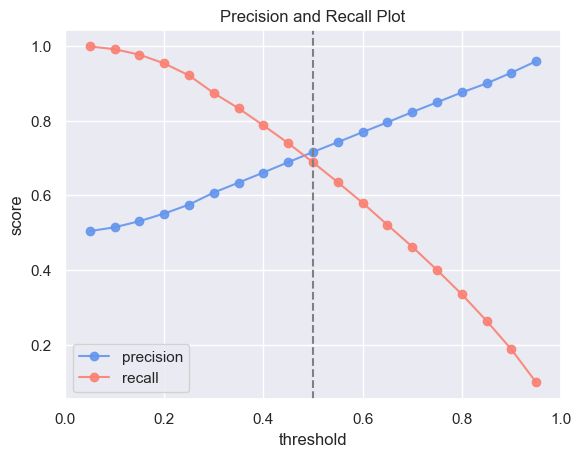

In [161]:
# Visualizing the result
plt.figure()

plt.plot(thresholds, precisions, label='precision', marker='o', color='cornflowerblue', alpha=0.9)
plt.plot(thresholds, recalls, label='recall', marker='o', color='salmon', alpha=0.9)

plt.title('Precision and Recall Plot')
plt.xlim(0, 1)
plt.axvline(np.median(thresholds), linestyle='--', color='gray')
plt.xlabel('threshold')
plt.ylabel('score')
plt.legend()

### Observations
- our precision and recall curves meet fairly cleanly and precisely in the middle at a threshold of 0.5, which is the default cutoff.
- if we were to prioritize recall, we would lower the threshold, and vice versa for precision.
- which of precision and recall we choose to prioritize depends on our use case.
- for now we will choose to keep the threshold at 0.5 to keep a good balance of precision and recall 

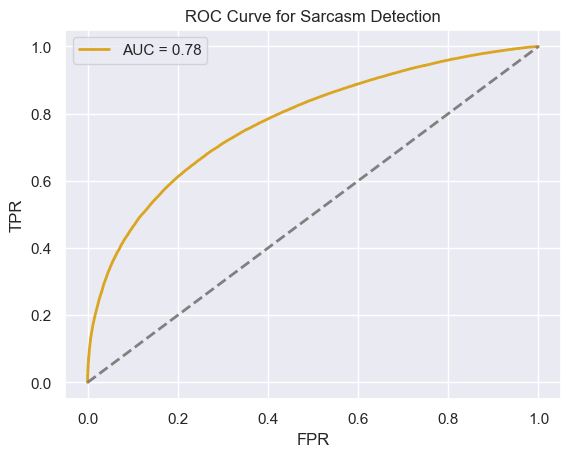

In [162]:
from sklearn.metrics import roc_curve, roc_auc_score

# setting 
fprs, tprs, thresholds = roc_curve(y_val, new_probas)
roc_auc = roc_auc_score(y_val, new_probas)


plt.figure()
plt.plot(fprs, tprs, color='goldenrod',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve for Sarcasm Detection')
plt.legend(loc="best")
plt.show()



### Conclusions about ROC
- AUC is a more all-encompassing measure than F1 score as it also considers the negative class whereas F1 score only considers the positive.
- our AUC is higher than our F1 scores because it actually does slightly better at predicting non-sarcastic comments
- the shape of our AUC curve implies that it performs consistently given varying thresholds and has no inclination toward either sensitivity or precision

------------------------------------------------------------------------------------------------------------------------------------------------------------

We will forego a confusion matrix as it will simply give us the raw output of our binary classification results, which we have already discussed above with precision, recall, and ROC.  

As a final measure of our model, we will run our test set through it to verify whether the results approximate our validation set.

In [149]:
test_report = classification_report(y_test, test_predict, target_names=['Non-Sarcastic', 'Sarcastic'])
print(test_report)

               precision    recall  f1-score   support

Non-Sarcastic       0.70      0.72      0.71    126187
    Sarcastic       0.71      0.69      0.70    126492

     accuracy                           0.71    252679
    macro avg       0.71      0.71      0.71    252679
 weighted avg       0.71      0.71      0.71    252679



The results on our test set match those of our validation, and we can use this accuracy score of 0.71 as our final result.

## <a href='#top' id='fin'>Conclusion</a>